# Finding Saddle-point Solutions with Chemical Potential Fields

This script demonstrates how to find the saddle-point solution of AB diblock copolymer systems with chemical potential fields (such as $w_A$, $w_B$, and $w_C$).

### 1. Setting simulation parameters and Initialization

\begin{align}
N &= 100 \\
\Delta s &= 1/N = 0.01 \\
L_x &= 2.0 bN^{1/2} \\
L_y &= 2.0 bN^{1/2} \\
V &= L_x L_y \\ 
m_x &= 64 \\
m_y &= 64 \\
b_A/b &= 1.0 \\
b_B/b &= 1.0 \\  
\chi N &= 20 \\
\end{align}

In numerical computation, $b^2N = 1$.

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"
os.environ["LFTS_NUM_GPUS"] = "1" # 1 ~ 2

# Simulation parameters
nx = [64,64]                       # grid number
lx = [2.0,2.0]                     # box size
stat_seg_lengths = {"A":1.0,       # statistical segment lengths
                    "B":1.0}        
ds = 0.01                          # contour step interval
chi_n = {"A,B":20}
monomer_types = ["A", "B"]  # monomer types

# Select platform ("cuda" or "cpu-mkl") for real-valued simulations
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", reduce_gpu_memory_usage, "real")
factory.display_info()

# Create an instance for computation box
cb = factory.create_computation_box(nx, lx) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("continuous", ds, stat_seg_lengths)

# Add AB diblock copolymers
volume_fraction = 1.0
blocks = [["A", 0.5, 0, 1],   # monomer type, statistical segment length, start index, end index
          ["B", 0.5, 1, 2]]
molecules.add_polymer(volume_fraction, blocks)

# Optimizer to avoid redundant computations
aggregate_propagator_computation = True
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

# Create a solver
solver = factory.create_pseudospectral_solver(cb, molecules, propagator_computation_optimizer)

==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors
--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, A:
	 X, (X, O), (50, 50), (B50)A, 1, {0,1}

0, B:
	 X, (X, O), (50, 50), (A50)B, 1, {2,1}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
B:
	 0, X, 50, 0, {50}, 
A:
	 0, X, 50, 0, {50}, 
(B50)A:
	 1, X, 50, 1, {}, 
(A50)B:
	 1, X, 50, 1, {}, 
Total number of modified diffusion equation steps (time complexity) to compute propagators: 200
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 0 %


### 2. Initial Potential Fields

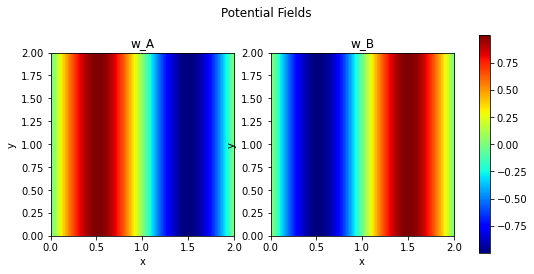

In [68]:
w_A =  np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for A
w_B = -np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for B
w = {"A": np.reshape(w_A, np.prod(nx)), "B": np.reshape(w_B, np.prod(nx))}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Potential Fields")
im = axes[0].imshow(w_A, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='x', ylabel='y')
axes[1].set(title='w_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 3. Finding the saddle-point solutions using an iterative method

Update the potential fields using the equations below: 

\begin{align}
{\bf R}_w &= X{\boldsymbol\phi} − P{\bf w}, \\
w_i({\bf r}, \tau+1) &= w_i({\bf r}, \tau) + \lambda_i ({\bf R}_w)_i, \\
\end{align}
where $\lambda_i$ is an update rate and $\tau$ is the iteration number.

##### Example 1) AB-type polymeric systems 

\begin{align}
{\bf R}_w =
\left[\begin{array}{cc} 
0 & \chi N \\ 
\chi N & 0
\end{array}\right]
\left[\begin{array}{cc} 
\phi_A({\bf r}) \\ 
\phi_B({\bf r}) 
\end{array}\right] &−
\left[\begin{array}{cc} 
\ \ 1/2 & -1/2 \\ 
-1/2 & \ \ 1/2
\end{array}\right]
\left[\begin{array}{cc} 
w_A({\bf r}) \\ 
w_B({\bf r}) 
\end{array}\right],
\end{align}

\begin{align}
w_A({\bf r}, \tau+1) &= w_A({\bf r}, \tau) + \lambda_A \left[\chi N \phi_B({\bf r}) - \frac{1}{2}(w_A({\bf r},\tau)-w_B({\bf r},\tau)) \right], \\
w_B({\bf r}, \tau+1) &= w_B({\bf r}, \tau) + \lambda_B \left[\chi N \phi_A({\bf r}) + \frac{1}{2}(w_A({\bf r},\tau)-w_B({\bf r},\tau)) \right]. \\
\end{align}

In [69]:
tolerance = 1.0e-5  # convergence tolerance
lambda_update = 0.5  # fields update rate

# The number of components
M = len(monomer_types)

# X (χN matrix) and its inverse
matrix_chi = np.array([
    [0, chi_n["A,B"]],
    [chi_n["A,B"], 0]]
)
matrix_chi_inv = np.linalg.inv(matrix_chi)

# P matrix for field residuals
matrix_p = np.identity(M) - np.matmul(np.ones((M,M)), matrix_chi_inv)/np.sum(matrix_chi_inv)

def compute_concentrations(w):
    # For the given fields, compute the polymer statistics
    solver.compute_propagators(w)
    solver.compute_concentrations()

    # Compute total concentration for each monomer type
    phi = {}
    for monomer_type in monomer_types:
        phi[monomer_type] = solver.get_total_concentration(monomer_type)

    return phi

# Assign large initial value for the energy and error
energy_total = 1.0e20
error_level = 1.0e20

# Iteration begins here
print("---------- Run ----------")
print("iteration, mass error, total_partitions, free_energy, error_level")
for scft_iter in range(1000):
    # Compute total concentration for each monomer type
    phi = compute_concentrations(w)

    # Calculate the total energy
    total_partitions = [solver.get_total_partition(p) for p in range(molecules.get_n_polymer_types())]
    energy_total = 0.0
    for i in range(M):
        energy_total -= np.mean(w[monomer_types[i]]*phi[monomer_types[i]])
        for j in range(M):
            energy_total += 0.5*matrix_chi[i,j]*np.mean(phi[monomer_types[i]]*phi[monomer_types[j]])

    # Calculate difference between current total density and target density
    phi_total = np.zeros(cb.get_total_grid())
    for i in range(M):
        phi_total += phi[monomer_types[i]]
    phi_diff = phi_total-1.0

    # Calculate self-consistency error
    w_diff = np.zeros([M, cb.get_total_grid()], dtype=np.float64) # array for output fields
    for i in range(M):
        for j in range(M):
            w_diff[i,:] += matrix_chi[i,j]*phi[monomer_types[j]] - matrix_p[i,j]*w[monomer_types[j]]

    # Keep the level of functional derivatives
    for i in range(M):
        w_diff[i] -= cb.integral(w_diff[i])/cb.get_volume()

    # error_level measures the "relative distance" between the input and output fields
    old_error_level = error_level
    error_level = 0.0
    error_normal = 1.0  # add 1.0 to prevent divergence
    for i in range(M):
        error_level += cb.inner_product(w_diff[i],w_diff[i])
        error_normal += cb.inner_product(w[monomer_types[i]],w[monomer_types[i]])
    error_level = np.sqrt(error_level/error_normal)

    # Print iteration # and error levels and check the mass conservation
    mass_error = cb.integral(phi_diff)/cb.get_volume()
    
    print("%8d %12.3E " % (scft_iter, mass_error), end=" [ ")
    for p in range(molecules.get_n_polymer_types()):
        print("%13.7E " % (solver.get_total_partition(p)), end=" ")
    print("] %15.9f %15.7E " % (energy_total, error_level))

    # Conditions to end the iteration
    if error_level < tolerance:
        break

    # Update fields using simple
    for i in range(M):
        w[monomer_types[i]] += lambda_update*w_diff[i]

---------- Run ----------
iteration, mass error, total_partitions, free_energy, error_level
       0   -1.174E-14  [ 1.0388142E+00  ]     5.017208820   4.9004111E-01 
       1   -2.315E-14  [ 1.0637937E+00  ]     5.027910979   5.1072641E-01 
       2   -6.025E-15  [ 1.1057239E+00  ]     5.045283903   5.2623990E-01 
       3    6.963E-15  [ 1.1776140E+00  ]     5.073661838   5.3596525E-01 
       4    1.483E-15  [ 1.3048712E+00  ]     5.120137480   5.4549022E-01 
       5   -1.451E-14  [ 1.5419187E+00  ]     5.198662736   5.4439153E-01 
       6    7.980E-16  [ 2.0137328E+00  ]     5.332343670   5.4523923E-01 
       7   -7.579E-15  [ 3.0396981E+00  ]     5.573997487   5.0566155E-01 
       8    6.196E-15  [ 5.3695232E+00  ]     5.959583801   4.5206266E-01 
       9   -1.171E-14  [ 1.0546779E+01  ]     6.507999086   3.4750522E-01 
      10    1.301E-14  [ 1.9763108E+01  ]     7.045656198   2.3330568E-01 
      11    1.010E-14  [ 3.2455180E+01  ]     7.514617822   1.5438403E-01 
      12

### 4. Show concentrations

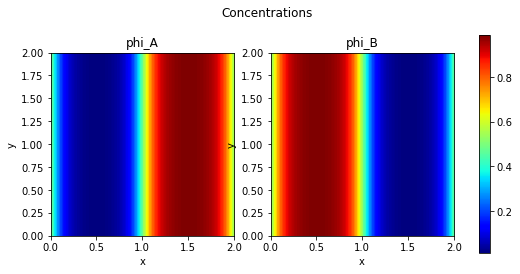

In [70]:
# Get the ensemble average concentration for each monomer type
phi_A = np.reshape(solver.get_total_concentration("A"), nx)
phi_B = np.reshape(solver.get_total_concentration("B"), nx)

# Plot each image with the same vmin and vmax
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Concentrations")
im = axes[0].imshow(phi_A, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(phi_B, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='phi_A', xlabel='x', ylabel='y')
axes[1].set(title='phi_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()